<center>

# <font colour = 'red'> **Business Case Study - EDA for Campaign Dataset**</font></center>

---



## **Importing Necessary Libraries and Data**

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [38]:
pd.set_option('display.max_columns', None)

In [352]:
campaign = pd.read_csv("/content/drive/MyDrive/Projects/Domain Analytics/Exploratory Data Analysis/campaign - campaign.csv")
df = pd.read_csv("/content/drive/MyDrive/Projects/Domain Analytics/Exploratory Data Analysis/campaign - campaign.csv")

## **Data Features**

In [40]:
# Shape of the campaigh  -
print("No. of Rows : ", df.shape[0])
print("No. of Columns : ", df.shape[1])

No. of Rows :  2239
No. of Columns :  27


In [41]:
# Checking for duplicate rows -
print("No. of duplicate rows: ", df.duplicated().sum())

No. of duplicate rows:  0


In [42]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2239 non-null   int64 
 1   Year_Birth           2239 non-null   int64 
 2   Education            2239 non-null   object
 3   Marital_Status       2239 non-null   object
 4   Income               2239 non-null   object
 5   Kidhome              2239 non-null   int64 
 6   Teenhome             2239 non-null   int64 
 7   Dt_Customer          2239 non-null   object
 8   Recency              2239 non-null   int64 
 9   MntWines             2239 non-null   int64 
 10  MntFruits            2239 non-null   int64 
 11  MntMeatProducts      2239 non-null   int64 
 12  MntFishProducts      2239 non-null   int64 
 13  MntSweetProducts     2239 non-null   int64 
 14  MntGoldProds         2239 non-null   int64 
 15  NumDealsPurchases    2239 non-null   int64 
 16  NumWeb

In [43]:
def missing_values(df):
    print("Missing Values")
    print("-"*15)
    missing = False
    for i in df.columns:
      missing_count = df[i].isna().sum()
      if missing_count > 0:
          print(f"{i} : {missing_count}")
          missing = True
    if not missing:
          print('No Missing Values in the DataFrame')

In [44]:
missing_values(df)

Missing Values
---------------
No Missing Values in the DataFrame


## **Data Preprocessing (Outlier Treatment & Feature Engineering)**

In [353]:
df['Income'] = df['Income'].str.replace('$', '').str.replace(',', '').astype(float)

In [354]:
df['Income'].isna().sum()

24

In [355]:
df['Income'] = df['Income'].fillna(df['Income'].mean())

In [356]:
df['AcceptedAnyCmp'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].max(axis=1)

In [357]:
education_order = ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
df['Education'] = pd.Categorical(df['Education'], categories=education_order, ordered=True)

df[['ID','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','AcceptedAnyCmp','Marital_Status','Complain']] = \
      df[['ID','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','AcceptedAnyCmp','Marital_Status','Complain']]\
          .astype('category')

In [358]:
print(f"kidhome:",df['Kidhome'].unique())
print(f"Teenhome:",df['Teenhome'].unique())

kidhome: [0 1 2]
Teenhome: [0 1 2]


In Data description it was given as Number of Kids and Teens in the house for `kidhome` and `teenhome`. But in the actual data it seems like of Boolean indicationg whether Kids and Teens are present(`bool 1`) or not (`bool 0`) in the household. Converting these to `category` type



In [359]:
df[['Kidhome', 'Teenhome']] = df[['Kidhome', 'Teenhome']].astype('bool')

In [360]:
df['Age'] = 2024 - df['Year_Birth']

In [361]:
df['Year_Birth'] = pd.to_datetime(df['Year_Birth'], format='%Y')

In [362]:
df["Dt_Customer"] = pd.to_datetime(df['Dt_Customer'],format='%m/%d/%y', errors='coerce')

In [363]:
df['Marital_Group'] = df['Marital_Status'].replace({
    'Married': 'In Couple', 'Together': 'In Couple',
    'Divorced': 'Alone', 'Single': 'Alone', 'Absurd': 'Alone',
    'Widow': 'Alone', 'YOLO': 'Alone'})

In [364]:
df['Tenure'] = pd.to_datetime('today').year - pd.to_datetime(df['Dt_Customer']).dt.year

### **Outlier & their Treatment**

In [365]:
def calculate_iqr(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound, iqr


def outlier_remove(df):
    for col in num_columns:
        lower_bound, upper_bound, iqr = calculate_iqr(df, col)
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]  # Removing outliers
    return df

In [402]:
num_columns = df.select_dtypes(include=['int64', 'float64']).columns

In [403]:
num_columns

Index(['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'Total_Spend'],
      dtype='object')

In [368]:
def outlier_function(df):
    outlier_columns = []
    outlier_ids = set()
    for col in num_columns:
        lower_bound, upper_bound, iqr = calculate_iqr(df, col)
        df_outlier = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        if df_outlier.shape[0] > 0:
            outlier_columns.append(col)
            outlier_ids.update(df_outlier['ID'])
            print(f'{col} - {df_outlier.shape[0]}, in percentage {round((df_outlier.shape[0]/df.shape[0])*100, 2)}%')

    return outlier_columns, outlier_ids


In [369]:
outlier_columns,outlier_ids = outlier_function(df)

Income - 7, in percentage 0.31%
MntWines - 35, in percentage 1.56%
MntFruits - 227, in percentage 10.14%
MntMeatProducts - 175, in percentage 7.82%
MntFishProducts - 223, in percentage 9.96%
MntSweetProducts - 248, in percentage 11.08%
MntGoldProds - 207, in percentage 9.25%
NumDealsPurchases - 86, in percentage 3.84%
NumWebPurchases - 4, in percentage 0.18%
NumCatalogPurchases - 23, in percentage 1.03%
NumWebVisitsMonth - 8, in percentage 0.36%
Age - 3, in percentage 0.13%


In [370]:
len(outlier_ids)

705

In [371]:
for col in num_columns:
    percentile_5 = np.percentile(df[col], 5)
    percentile_95 = np.percentile(df[col], 95)
    df[col] = np.round(np.clip(df[col], percentile_5, percentile_95),2)

In [372]:
outlier_columns,outlier_ids = outlier_function(df)

MntFruits - 227, in percentage 10.14%
MntMeatProducts - 175, in percentage 7.82%
MntFishProducts - 223, in percentage 9.96%
MntSweetProducts - 248, in percentage 11.08%
MntGoldProds - 207, in percentage 9.25%


In [373]:
len(outlier_ids)

607

In [374]:
# still there are some extreme vaalues in the data set lets try to clip them at 90 percentile
outliers = ['MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
for col in num_columns:
    percentile_5 = np.percentile(df[col], 5)
    percentile_90 = np.percentile(df[col], 90)
    df[col] = np.round(np.clip(df[col], percentile_5, percentile_90),2)

In [377]:
outlier_columns,outlier_ids = outlier_function(df)

MntFruits - 227, in percentage 10.14%
MntSweetProducts - 248, in percentage 11.08%


In [379]:
median_income = df['Income'].median()
df['Income_Bracket'] = pd.cut(df['Income'], bins=[0, median_income, df['Income'].max()], labels=['Below Median', 'Above Median'])

In [380]:
bins = [0,20000,40000,60000,80000,100000,120000,140000,160000,180000,200000]
labels = ['0-20K', '20K-40K', '40K-60K', '60K-80K', '80K-100K', '100K-120K', '120K-140K', '140K-160K', '160K-180K', '180K-200K']
df['Income_Bins'] = pd.cut(df['Income'], bins = bins, labels = labels)

In [395]:
df['Total_Spend'] = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                         'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

In [396]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2239 non-null   category      
 1   Year_Birth           2239 non-null   datetime64[ns]
 2   Education            2239 non-null   category      
 3   Marital_Status       2239 non-null   category      
 4   Income               2239 non-null   float64       
 5   Kidhome              2239 non-null   bool          
 6   Teenhome             2239 non-null   bool          
 7   Dt_Customer          2239 non-null   datetime64[ns]
 8   Recency              2239 non-null   int64         
 9   MntWines             2239 non-null   float64       
 10  MntFruits            2239 non-null   int64         
 11  MntMeatProducts      2239 non-null   float64       
 12  MntFishProducts      2239 non-null   float64       
 13  MntSweetProducts     2239 non-nul

In [219]:
# lower_bound,upper_bound,iqr = calculate_iqr(df,"MntFruits")
# df_outlier_fruit = df[(df['MntFruits'] < (lower_bound)) | (df['MntFruits'] > (upper_bound))]
# fruit_outlier = df_outlier_fruit['ID'].tolist()

# lower_bound,upper_bound,iqr = calculate_iqr(df,"MntSweetProducts")
# df_outlier_sweet = df[(df['MntSweetProducts'] < (lower_bound)) | (df['MntSweetProducts'] > (upper_bound))]
# sweet_outlier = df_outlier_sweet['ID'].tolist()

# # df.query('ID in @sweet_outlier & ID in @fruit_outlier').shape[0]

In [348]:
# df = df.query('ID not in @outlier_ids')

## **EDA**

In [401]:
len(num_columns)

14

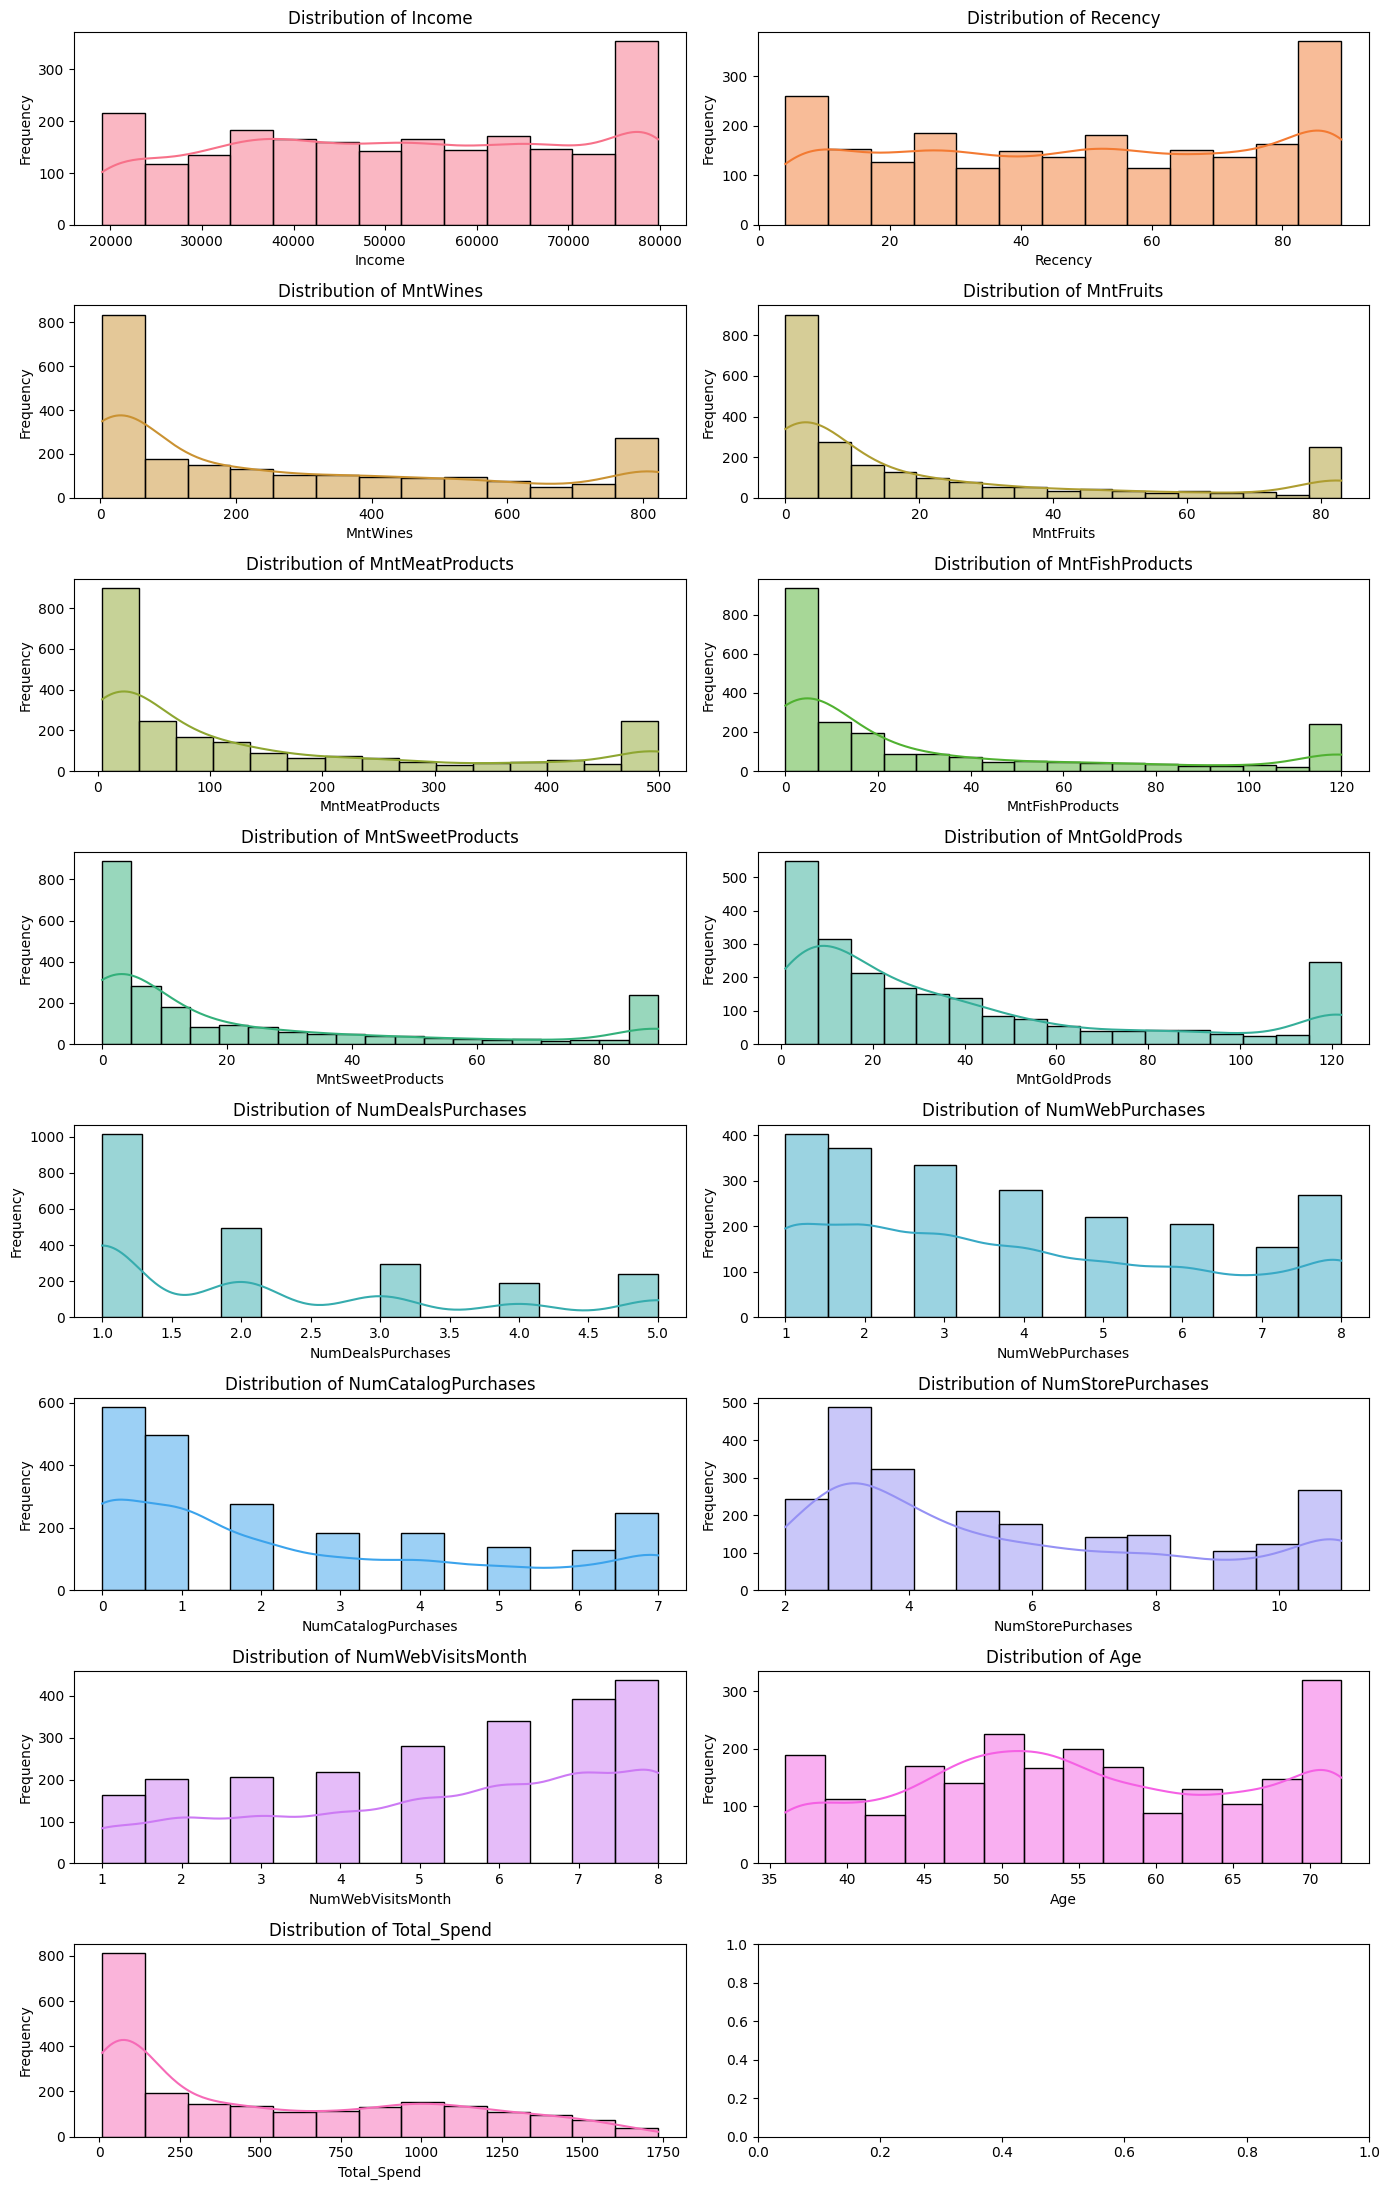

In [407]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(14, 22))
#color = ['red', 'green', 'hotpink', 'orange', 'lightcoral', 'grey','red', 'green', 'hotpink', 'orange','lightcoral', 'grey','red', 'green','hotpink']
color = sns.color_palette("husl", len(num_columns))
counter = 0

for i in range(8):
    for j in range(2):
        sns.histplot(data=df, x=num_columns[counter], kde=True, color=color[counter], ax=axes[i, j])
        axes[i, j].set_title(f"Distribution of {num_columns[counter]}")
        axes[i, j].set_xlabel(num_columns[counter])
        axes[i, j].set_ylabel("Frequency")
        counter += 1
        if counter == 15:
            break
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

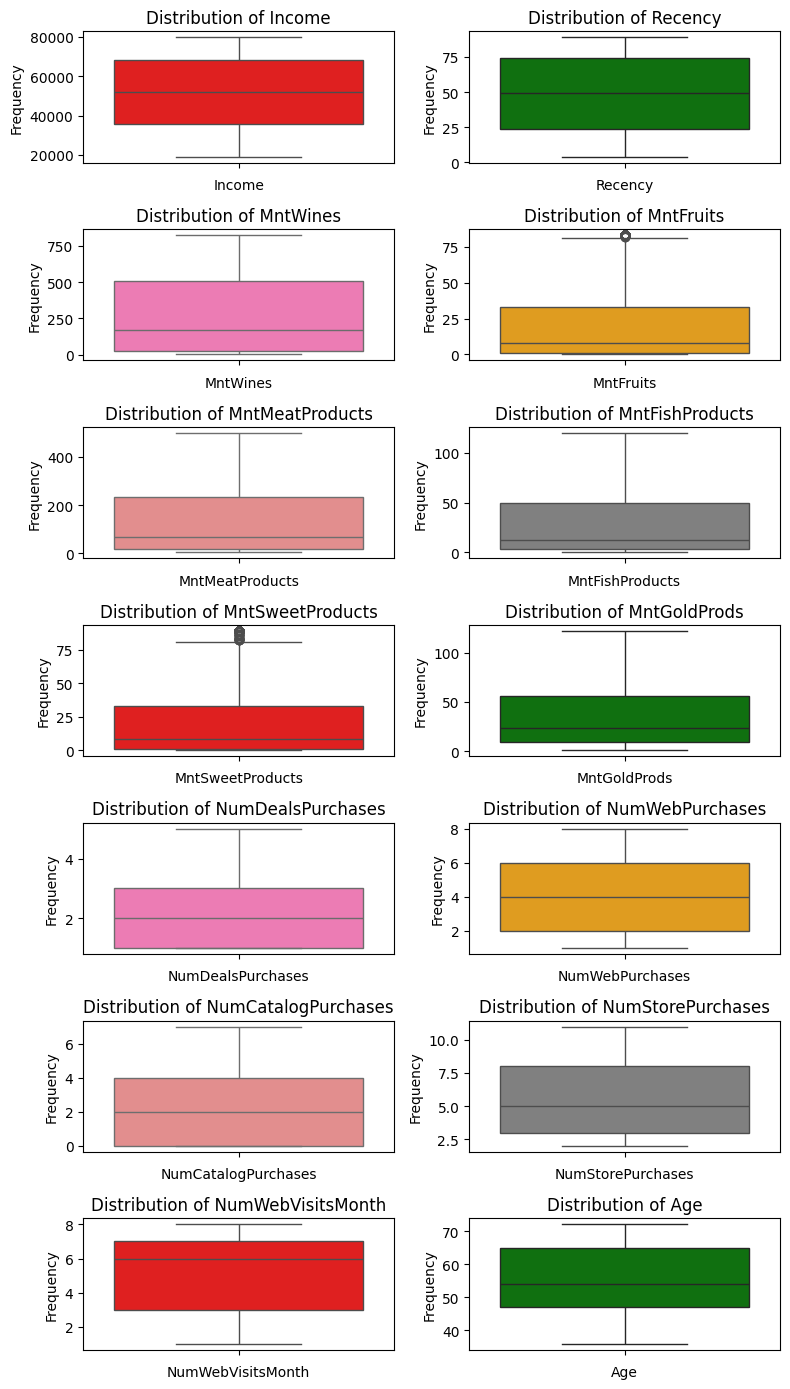

In [378]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(8, 14))
color = ['red', 'green', 'hotpink', 'orange', 'lightcoral', 'grey','red', 'green', 'hotpink', 'orange','lightcoral', 'grey','red', 'green']
counter = 0

for i in range(7):
    for j in range(2):
        sns.boxplot(data=df, y = num_columns[counter], color=color[counter], ax=axes[i, j])
        axes[i, j].set_title(f"Distribution of {num_columns[counter]}")
        axes[i, j].set_xlabel(num_columns[counter])
        axes[i, j].set_ylabel("Frequency")
        counter += 1
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

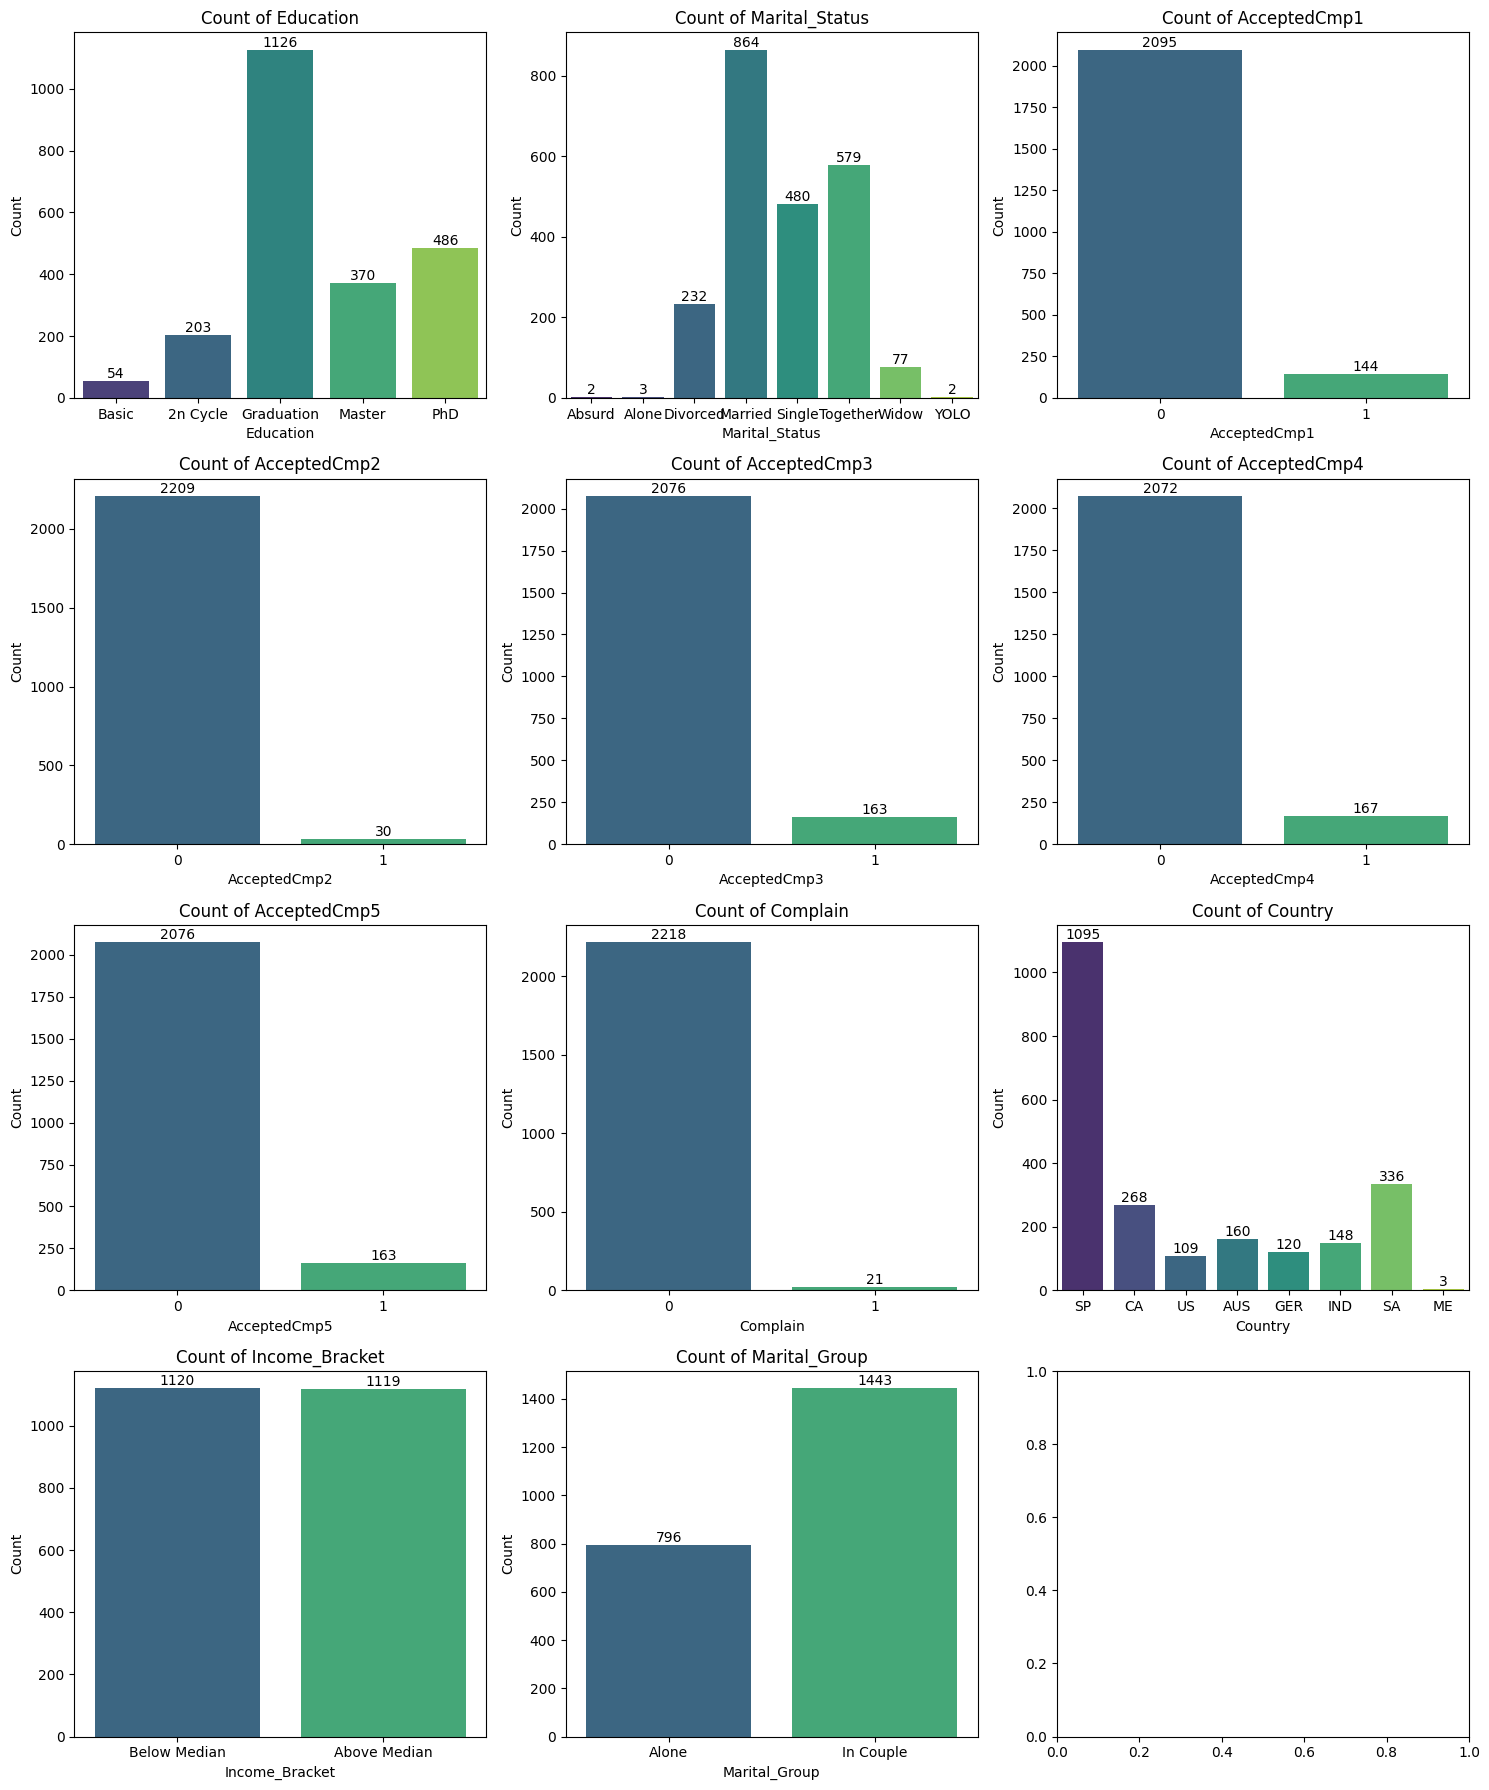

In [393]:
# Count plots for categorical columns
cat_columns = ['Education', 'Marital_Status', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Country', 'Income_Bracket', 'Marital_Group']

fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15,18))
plot_number = 0
for i in range(4):
  for j in range(3):
    sns.countplot(data = df, x = cat_columns[plot_number],palette='viridis', ax = axes[i,j])
    for p in axes[i,j].containers:
      axes[i,j].bar_label(p)
    axes[i,j].set_title(f"Count of {cat_columns[plot_number]}")
    axes[i,j].set_xlabel(cat_columns[plot_number])
    axes[i,j].set_ylabel('Count')
    plot_number += 1
    if plot_number == 11:
      break
plt.tight_layout()
plt.show()


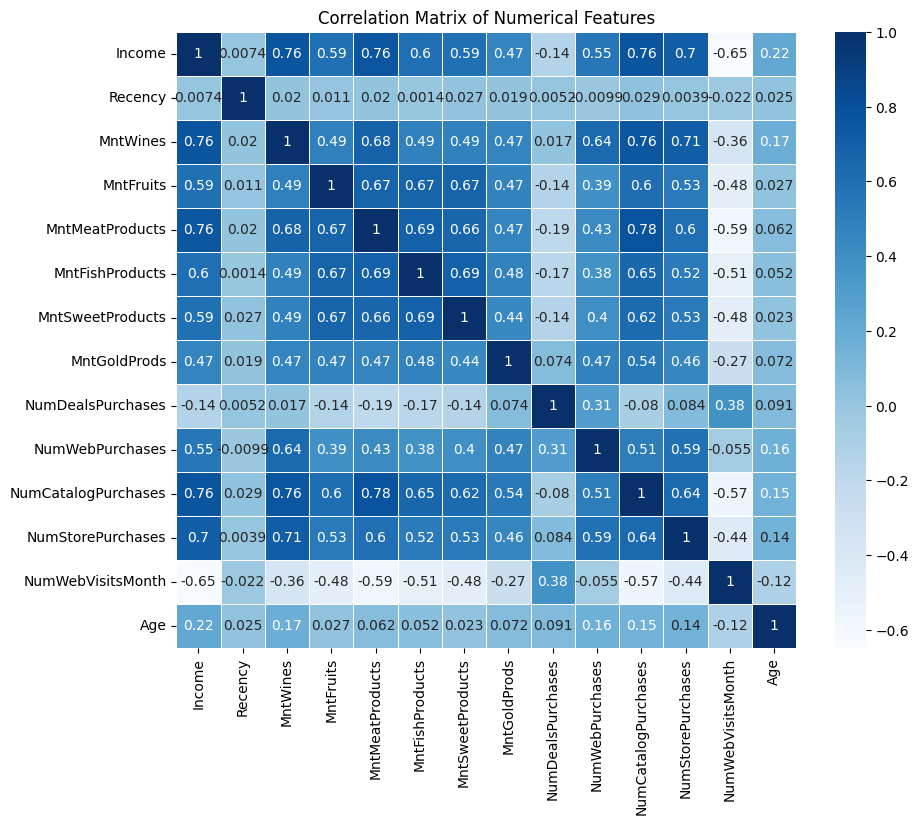

In [394]:
plt.figure(figsize=(10, 8))
corr_matrix = df[num_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

11

## Hypothesis Testing


### Hypothesis 1: Is income dependent on education?

**Null Hypothesis (Ho)** - There is no significant dependenc on education and Income.

**Alternate Hypothesis (Ha)** - There is significant dependence on education and Income.


In [412]:
# Chi-square test for independence
contingency_table = pd.crosstab(df['Education'], pd.qcut(df['Income'], q=4))  # Binning income into quartiles
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)


print(f"Test Statistic : {chi2}", end = "\n")
print(f"p - value : {p}", end ='\n')
print(f"Degree of Freedom : {dof}", end ='\n')
print(f"Expected Table : {expected}")

Test Statistic : 213.6015720330066
p - value : 5.027093802243061e-39
Degree of Freedom : 12
Expected Table : [[ 13.50602948  13.50602948  13.48191157  13.50602948]
 [ 50.77266637  50.77266637  50.68200089  50.77266637]
 [281.62572577 281.62572577 281.12282269 281.62572577]
 [ 92.54131309  92.54131309  92.37606074  92.54131309]
 [121.5542653  121.5542653  121.33720411 121.5542653 ]]


In [414]:
alpha = 0.05
if p <= 0.05:
  print("Reject the Null Hypothesis (Ho)")
  print("There is signififcant dependenc on education and Income")
else:
  print("Failed to Reject the Null Hypothesis (Ho)")
  print("There is no dependenc on education and Income")

Reject the Null Hypothesis (Ho)
There is signififcant dependenc on education and Income


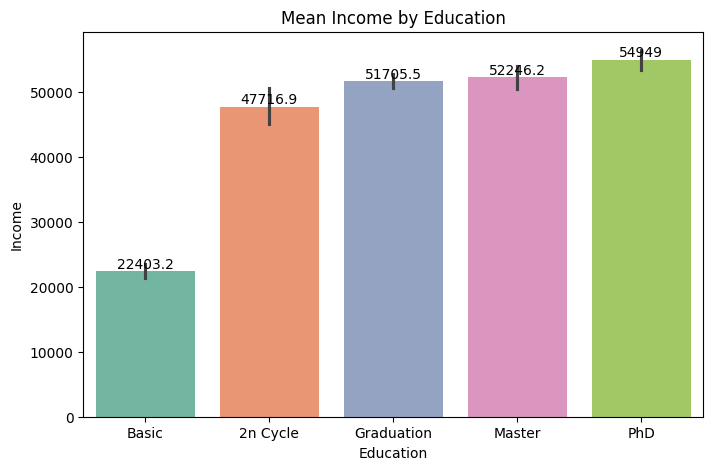

In [416]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(y='Income', x = 'Education', data=df, palette='Set2')
for i in ax.containers:
    ax.bar_label(i)
plt.title('Mean Income by Education')
plt.show()

## Hypothesis 2: Do higher-income people spend more?

**Null Hypothesis (Ho)** - There is no correlation between Income and Total Spend.

**Alternate Hypothesis (Ha)** - There is significant correlation between Income and Total Spend.

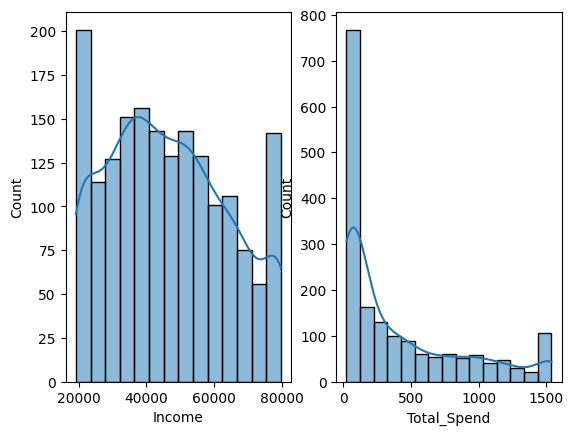

In [ ]:
plt.subplot(1,2,1)
sns.histplot(data = df, x = 'Income', kde = True)
plt.subplot(1,2,2)
sns.histplot(data = df, x = 'Total_Spend', kde = True)
plt.show()

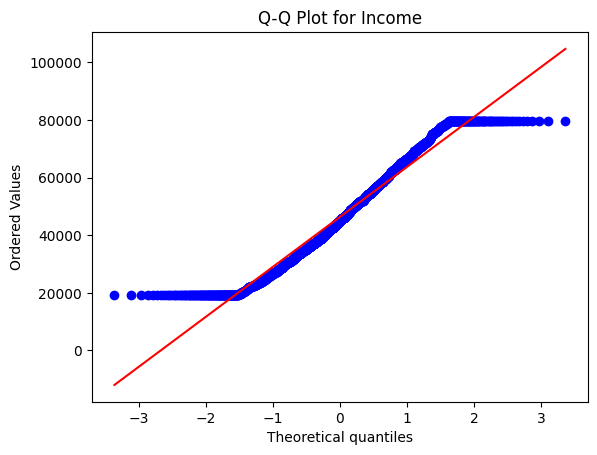

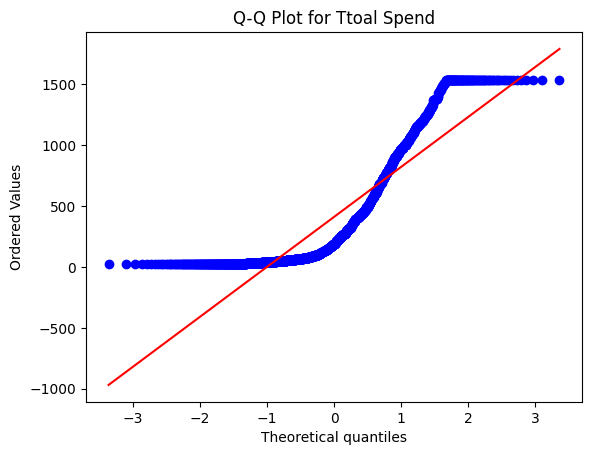

In [ ]:
stats.probplot(df['Income'], dist="norm", plot=plt)
plt.title("Q-Q Plot for Income")
plt.show()

stats.probplot(df['Total_Spend'], dist="norm", plot=plt)
plt.title("Q-Q Plot for Ttoal Spend")
plt.show()


In [ ]:
# Correlation test (Spearman since is normally distributed)
correlation, p_value = stats.spearmanr(df['Income'], df['Total_Spend'])
print(f'Spearman Correlation: {correlation}, p-value: {p_value}')

Spearman Correlation: 0.7930133976926123, p-value: 0.0


In [ ]:
alpha = 0.05   # significance of 95% (recommended for no significance is mentioned)
if p_value <= 0.05:
  print("Reject the Null Hypothesis (Ho)")
  print("There is signififcant correlation between Income and Total Spend")
else:
  print("Failed to Reject the Null Hypothesis (Ho)")
  print("There is no significant correlation between Income and Total Spend")

Reject the Null Hypothesis (Ho)
There is signififcant correlation between Income and Total Spend


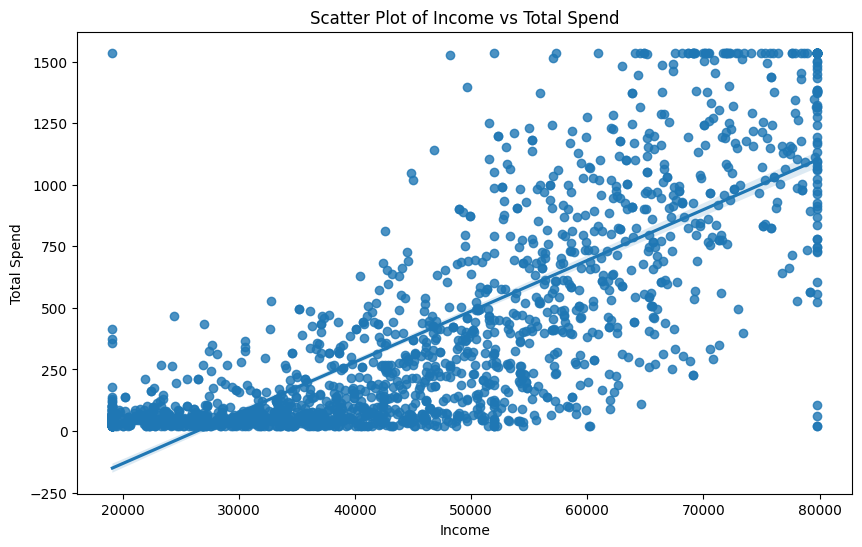

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Income', y='Total_Spend', data=df)
plt.title('Scatter Plot of Income vs Total Spend')
plt.xlabel('Income')
plt.ylabel('Total Spend')
plt.show()

**Observation:**
There is a strong positive monotonic relationship between Income and Total_Spend. This means that as Income increases, Total_Spend tends to increase as well.

## Hypothesis 3: Do couples spend more on wine than people living alone?
**Null Hypothesis (Ho)** : Marital Status doesn't have any dependency on Wine Sales

**Alternate Hypothesis (Ha)** : Marital Status does have dependency on Wine Sales

In [ ]:
# Independent t-test
couples = df[df['Marital_Group'] == 'In Couple']['MntWines']
alone = df[df['Marital_Group'] == 'Alone']['MntWines']

t_stat, p_value = stats.ttest_ind(couples, alone)
print(f't-statistic: {t_stat}, p-value: {p_value}')

t-statistic: -0.1268355596302169, p-value: 0.8990849487311653


In [ ]:
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
    print("Marital Status and Wine Sales are dependent")
else:
    print("Failed to reject the null hypothesis")
    print("Marital Status and Wine Sales are independent")

Failed to reject the null hypothesis
Marital Status and Wine Sales are independent


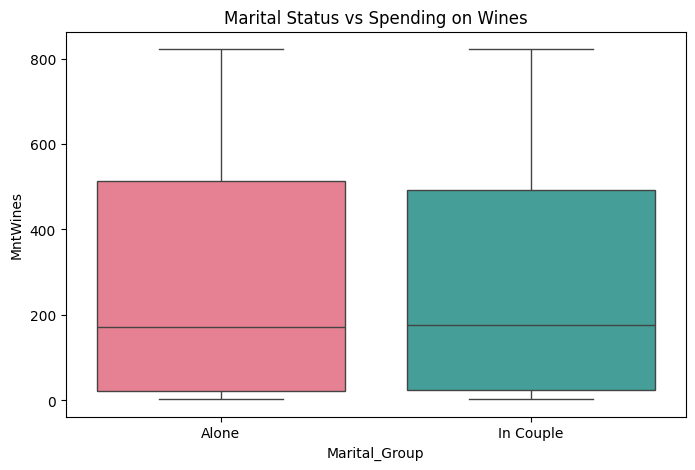

In [408]:
# Marital Status vs Spending on Wines
plt.figure(figsize=(8, 5))
sns.boxplot(x='Marital_Group', y='MntWines', data=df, palette='husl')
plt.title('Marital Status vs Spending on Wines')
plt.show()

## Hypothesis 4: Are lower-income people more attracted to campaigns?

In [ ]:
contingency_table = pd.crosstab(df['Income_Bracket'], df['AcceptedAnyCmp'])
contingency_table

AcceptedAnyCmp,0,1
Income_Bracket,,
Below Median,983,116
Above Median,462,212


In [ ]:
# Chi-square test for independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f'Chi-square Statistic: {chi2}, p-value: {p}')


Chi-square Statistic: 119.64249394495877, p-value: 7.5753522640493685e-28


In [ ]:
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
    print("Income Braackets and Campaigns are dependent")
else:
    print("Failed to reject the null hypothesis")
    print("Income Braackets and Campaigns are independent")

Failed to reject the null hypothesis
Income Braackets and Campaigns are independent


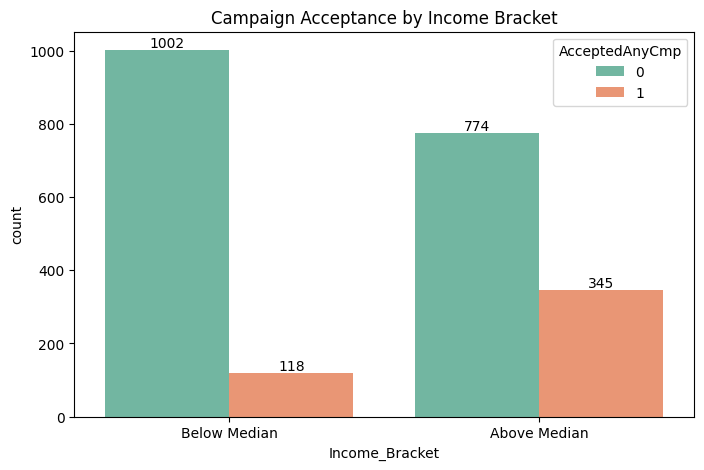

In [410]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Income_Bracket', hue='AcceptedAnyCmp', data=df, palette='Set2')
for i in ax.containers:
    ax.bar_label(i)
plt.title('Campaign Acceptance by Income Bracket')
plt.show()